In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from wordcloud import WordCloud
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import VotingClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import nltk
# Download NLTK resources (uncomment if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# File paths
train_file = r'C:\Users\admin\OneDrive\Desktop\capstone-2\train_data.csv'
test_file = r'C:\Users\admin\OneDrive\Desktop\capstone-2\test_data.csv'
hidden_test_file = r'C:\Users\admin\OneDrive\Desktop\capstone-2\test_data_hidden.csv'

In [3]:
# Load datasets
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
hidden_test_data = pd.read_csv(hidden_test_file)

# Data cleaning and preprocessing

In [4]:
train_data.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [5]:
train_data.shape

(4000, 8)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  4000 non-null   object
 1   Product Brand        4000 non-null   object
 2   categories           4000 non-null   object
 3   primaryCategories    4000 non-null   object
 4   reviews.date         4000 non-null   object
 5   reviews.text         4000 non-null   object
 6   reviews.title        3990 non-null   object
 7   sentiment            4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB


In [7]:
train_data.isnull().sum()

Name of the product     0
Product Brand           0
categories              0
primaryCategories       0
reviews.date            0
reviews.text            0
reviews.title          10
sentiment               0
dtype: int64

In [8]:
# Impute missing values in 'reviews.title' with the mode
mode_title = train_data['reviews.title'].mode()[0]
train_data['reviews.title'].fillna(mode_title, inplace=True)

In [9]:
train_data.describe()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,4000,4000,4000,4000,4000,4000,4000,4000
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,676,4000,628,2600,99,4,110,3749


In [10]:
train_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')

In [11]:
# Define function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    # Join tokens back into text
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

# Apply text preprocessing to 'reviews.text' and 'reviews.title' columns
train_data['reviews.text'] = train_data['reviews.text'].apply(preprocess_text)
train_data['reviews.title'] = train_data['reviews.title'].apply(preprocess_text)

In [12]:
# Print the preprocessed 'reviews.text' and 'reviews.title'
print("Preprocessed 'reviews.text':")
train_data['reviews.text'].head()

Preprocessed 'reviews.text':


0    purchased black fridaypros great price even sa...
1    purchased two amazon echo plus two dot plus fo...
2    average alexa option show thing screen still l...
3               good product exactly wanted good price
4    rd one ive purchased ive bought one niece case...
Name: reviews.text, dtype: object

In [13]:
print("\nPreprocessed 'reviews.title':")
train_data['reviews.title'].head()


Preprocessed 'reviews.title':


0             powerful tablet
1    amazon echo plus awesome
2                     average
3                 greattttttt
4                     durable
Name: reviews.title, dtype: object

In [14]:
# Handling categorical variables (example: Label encoding for 'Product Brand')
label_encoder = LabelEncoder()
train_data['Product Brand'] = label_encoder.fit_transform(train_data['Product Brand'])
label_encoder

LabelEncoder()

In [15]:
# Save cleaned and preprocessed data
cleaned_file_path = r'C:\Users\admin\OneDrive\Desktop\capstone-2\cleaned_train_data.csv'
train_data.to_csv(cleaned_file_path, index=False)

# Display columns after cleaning
print("\nColumns after cleaning and preprocessing:")
print(train_data.columns)


Columns after cleaning and preprocessing:
Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')


In [16]:
train_data.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",0,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,purchased black fridaypros great price even sa...,powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,0,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,purchased two amazon echo plus two dot plus fo...,amazon echo plus awesome,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,average alexa option show thing screen still l...,average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",0,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,good product exactly wanted good price,greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",0,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,rd one ive purchased ive bought one niece case...,durable,Positive


### test_data

In [17]:
test_data.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


In [18]:
test_data.shape

(1000, 7)

In [19]:
test_data.isnull().sum()

Name of the product    0
Product Brand          0
categories             0
primaryCategories      0
reviews.date           0
reviews.text           0
reviews.title          3
dtype: int64

In [20]:
test_data.describe()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,1000,1000,1000,1000,1000,1000,997
unique,23,1,23,4,366,979,796
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought the white version and have it in the ...,Great tablet
freq,169,1000,169,676,26,2,22


In [21]:
# Impute missing values in 'reviews.title' with the mode
mode_title = test_data['reviews.title'].mode()[0]
test_data['reviews.title'].fillna(mode_title, inplace=True)


In [22]:
test_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title'],
      dtype='object')

In [23]:
# Define function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    # Join tokens back into text
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

# Apply text preprocessing to 'reviews.text' and 'reviews.title' columns
test_data['reviews.text'] = test_data['reviews.text'].apply(preprocess_text)
test_data['reviews.title'] = test_data['reviews.title'].apply(preprocess_text)


In [24]:
# Print the preprocessed 'reviews.text' and 'reviews.title'
print("Preprocessed 'reviews.text':")
test_data['reviews.text'].head()

Preprocessed 'reviews.text':


0    amazon kindle fire lot free app used one want ...
1    echo show great addition amazon family work li...
2           great value best buy bought christmas sale
3    use mine email facebook game go line also load...
4                    fantastic item person bought love
Name: reviews.text, dtype: object

In [25]:
print("\nPreprocessed 'reviews.title':")
test_data['reviews.title'].head()


Preprocessed 'reviews.title':


0               handy device
1      another winner amazon
2    simple use reliable far
3                       love
4                  fantastic
Name: reviews.title, dtype: object

In [26]:
# Handle categorical variables (example: Label encoding for 'Product Brand')
label_encoder = LabelEncoder()
test_data['Product Brand'] = label_encoder.fit_transform(test_data['Product Brand'])

In [27]:
# Save cleaned and preprocessed data
cleaned_file_path = r'C:\Users\admin\OneDrive\Desktop\capstone-2\cleaned_test_data.csv'
test_data.to_csv(cleaned_file_path, index=False)

# Display columns after cleaning
print("\nColumns after cleaning and preprocessing:")
print(test_data.columns)


Columns after cleaning and preprocessing:
Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title'],
      dtype='object')


In [28]:
# Print first few rows after preprocessing
print("\nFirst few rows after cleaning and preprocessing:")
test_data.head()


First few rows after cleaning and preprocessing:


,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",0,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,amazon kindle fire lot free app used one want ...,handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,echo show great addition amazon family work li...,another winner amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",0,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,great value best buy bought christmas sale,simple use reliable far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",0,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,use mine email facebook game go line also load...,love
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,fantastic item person bought love,fantastic


### hidden_test_data

In [29]:
hidden_test_data.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Positive


In [30]:
hidden_test_data.shape

(1000, 8)

In [31]:
hidden_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  1000 non-null   object
 1   Product Brand        1000 non-null   object
 2   categories           1000 non-null   object
 3   primaryCategories    1000 non-null   object
 4   reviews.date         1000 non-null   object
 5   reviews.text         1000 non-null   object
 6   reviews.title        997 non-null    object
 7   sentiment            1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB


In [32]:
hidden_test_data.isnull().sum()

Name of the product    0
Product Brand          0
categories             0
primaryCategories      0
reviews.date           0
reviews.text           0
reviews.title          3
sentiment              0
dtype: int64

In [33]:
hidden_test_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')

In [34]:
# Impute missing values in 'reviews.title' with the mode
mode_title = hidden_test_data['reviews.title'].mode()[0]
hidden_test_data['reviews.title'].fillna(mode_title, inplace=True)
 

In [35]:
hidden_test_data.describe()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,1000,1000,1000,1000,1000,1000,1000,1000
unique,23,1,23,4,366,979,796,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought the white version and have it in the ...,Great tablet,Positive
freq,169,1000,169,676,26,2,25,937


In [36]:
# Example preprocess_text function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Convert non-string values to empty strings
hidden_test_data['reviews.text'] = hidden_test_data['reviews.text'].astype(str)
hidden_test_data['reviews.title'] = hidden_test_data['reviews.title'].astype(str)

# Apply text preprocessing to 'reviews.text' and 'reviews.title' columns
hidden_test_data['reviews.text'] = hidden_test_data['reviews.text'].apply(preprocess_text)
hidden_test_data['reviews.title'] = hidden_test_data['reviews.title'].apply(preprocess_text)

In [37]:
# Print the preprocessed 'reviews.text' and 'reviews.title'
print("Preprocessed 'reviews.text':")
hidden_test_data['reviews.text'].head()

Preprocessed 'reviews.text':


0    amazon kindle fire has a lot of free app and c...
1    the echo show is a great addition to the amazo...
2    great value from best buy bought at christmas ...
3    i use mine for email facebook games and to go ...
4    this is a fantastic item  the person i bought ...
Name: reviews.text, dtype: object

In [38]:
print("\nPreprocessed 'reviews.title':")
hidden_test_data['reviews.title'].head()


Preprocessed 'reviews.title':


0                    very handy device
1           another winner from amazon
2    simple to use and reliable so far
3                              love it
4                            fantastic
Name: reviews.title, dtype: object

In [39]:
# Handle categorical variables (example: Label encoding for 'Product Brand')
label_encoder = LabelEncoder()
hidden_test_data['Product Brand'] = label_encoder.fit_transform(hidden_test_data['Product Brand'])

In [40]:
# Save cleaned and preprocessed data
cleaned_file_path = r'C:\Users\admin\OneDrive\Desktop\capstone-2\cleaned_hidden_test_data.csv'
hidden_test_data.to_csv(cleaned_file_path, index=False)

# Display columns after cleaning
print("\nColumns after cleaning and preprocessing:")
print(hidden_test_data.columns)


Columns after cleaning and preprocessing:
Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')


In [41]:
# Print first few rows after preprocessing
print("\nFirst few rows after cleaning and preprocessing:")
hidden_test_data.head()


First few rows after cleaning and preprocessing:


,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",0,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,the echo show is a great addition to the amazo...,another winner from amazon,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",0,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,great value from best buy bought at christmas ...,simple to use and reliable so far,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",0,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,i use mine for email facebook games and to go ...,love it,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,this is a fantastic item the person i bought ...,fantastic,Positive


### Normalize text data

In [42]:
import string
# Function to normalize text data (lowercase and remove punctuation)
def normalize_text(text):
    text = text.lower()  # Convert text to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

# Columns to normalize
columns_to_normalize = ['reviews.text', 'reviews.title']

# Apply normalization function to train_data
for col in columns_to_normalize:
    train_data[col] = train_data[col].apply(normalize_text)

# Apply normalization function to test_data
for col in columns_to_normalize:
    test_data[col] = test_data[col].apply(normalize_text)

# Apply normalization function to hidden_test_data
for col in columns_to_normalize:
    hidden_test_data[col] = hidden_test_data[col].apply(normalize_text)

# Display normalized data (optional)
print("Normalized train_data:")
train_data.head()

Normalized train_data:


,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",0,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,purchased black fridaypros great price even sa...,powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,0,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,purchased two amazon echo plus two dot plus fo...,amazon echo plus awesome,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,average alexa option show thing screen still l...,average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",0,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,good product exactly wanted good price,greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",0,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,rd one ive purchased ive bought one niece case...,durable,Positive


In [43]:
print("\nNormalized test_data:")
test_data.head(2)


Normalized test_data:


,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",0,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,amazon kindle fire lot free app used one want ...,handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,echo show great addition amazon family work li...,another winner amazon


In [44]:
print("\nNormalized hidden_test_data:")
hidden_test_data.head(2)


Normalized hidden_test_data:


,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",0,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,the echo show is a great addition to the amazo...,another winner from amazon,Positive


### Tokenization and stemming/lemmatization.

In [45]:
# Function to tokenize text data
def tokenize_text(text):
    tokens = word_tokenize(text)  # Tokenize text into words
    return tokens

# Function to perform stemming
def stem_text(tokens):
    stemmer = PorterStemmer()  # Initialize Porter Stemmer
    stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Stem each token
    return stemmed_tokens

# Function to perform lemmatization
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()  # Initialize WordNet Lemmatizer
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize each token
    return lemmatized_tokens

# Columns to tokenize, stem, and lemmatize
columns_to_process = ['reviews.text', 'reviews.title']

# Apply tokenization, stemming, and lemmatization to train_data
for col in columns_to_process:
    train_data[col] = train_data[col].apply(lambda x: tokenize_text(x))  # Tokenize
    train_data[col] = train_data[col].apply(lambda x: stem_text(x))  # Stem
    train_data[col] = train_data[col].apply(lambda x: lemmatize_text(x))  # Lemmatize

# Apply tokenization, stemming, and lemmatization to test_data
for col in columns_to_process:
    test_data[col] = test_data[col].apply(lambda x: tokenize_text(x))  # Tokenize
    test_data[col] = test_data[col].apply(lambda x: stem_text(x))  # Stem
    test_data[col] = test_data[col].apply(lambda x: lemmatize_text(x))  # Lemmatize

# Apply tokenization, stemming, and lemmatization to hidden_test_data
for col in columns_to_process:
    hidden_test_data[col] = hidden_test_data[col].apply(lambda x: tokenize_text(x))  # Tokenize
    hidden_test_data[col] = hidden_test_data[col].apply(lambda x: stem_text(x))  # Stem
    hidden_test_data[col] = hidden_test_data[col].apply(lambda x: lemmatize_text(x))  # Lemmatize

In [46]:
# Display processed data (optional)
print("Processed train_data:")
train_data.head(2)

Processed train_data:


,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",0,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,"[purchas, black, fridaypro, great, price, even...","[power, tablet]",Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,0,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,"[purchas, two, amazon, echo, plu, two, dot, pl...","[amazon, echo, plu, awesom]",Positive


In [47]:
print("\nProcessed test_data:")
test_data.head(2)


Processed test_data:


,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",0,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,"[amazon, kindl, fire, lot, free, app, use, one...","[handi, devic]"
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,"[echo, show, great, addit, amazon, famili, wor...","[anoth, winner, amazon]"


In [48]:
print("\nProcessed hidden_test_data:")
hidden_test_data.head(2)


Processed hidden_test_data:


,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",0,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,"[amazon, kindl, fire, ha, a, lot, of, free, ap...","[veri, handi, devic]",Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,"[the, echo, show, is, a, great, addit, to, the...","[anoth, winner, from, amazon]",Positive


# Exploratory Data Analysis (EDA):

In [49]:
# Summary statistics
print("Summary Statistics:")
train_data.describe()


Summary Statistics:


,Product Brand
count,4000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [50]:
# Count unique values
print("\nUnique Values in 'sentiment' column:")
train_data['sentiment'].value_counts()


Unique Values in 'sentiment' column:


Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64

C:\Users\admin\AppData\Local\Temp\ipykernel_11584\2624921216.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis', hue=None)


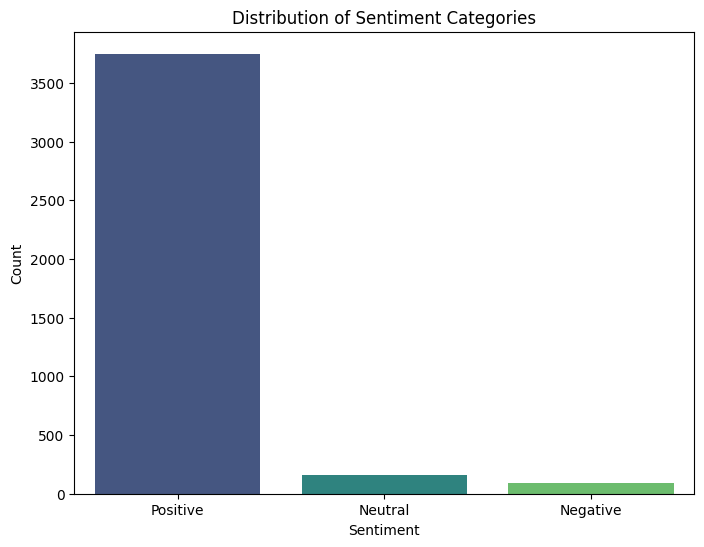

In [51]:
# Count the number of instances in each sentiment category
sentiment_counts = train_data['sentiment'].value_counts()

# Plot the distribution of sentiment categories
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis', hue=None)
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [52]:
# Calculate the percentage of each sentiment category
sentiment_percentage = sentiment_counts / sentiment_counts.sum() * 100
print(sentiment_percentage)

Positive    93.725
Neutral      3.950
Negative     2.325
Name: sentiment, dtype: float64


C:\Users\admin\AppData\Local\Temp\ipykernel_11584\3223477082.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_percentage.index, y=sentiment_percentage.values, palette='viridis')


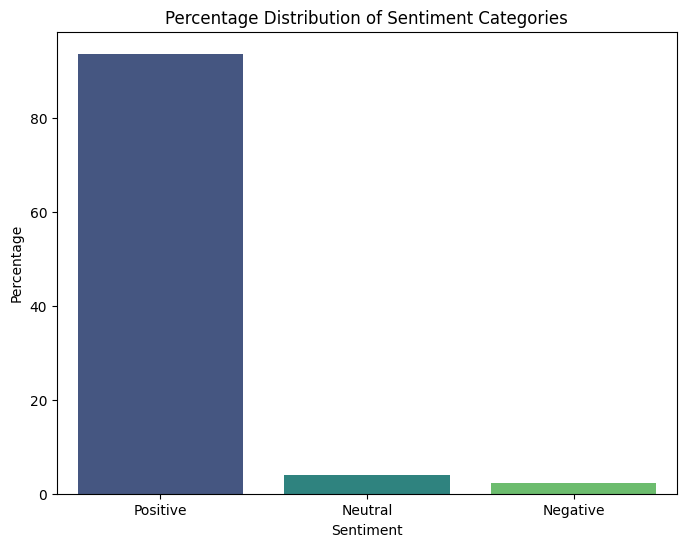

In [53]:
# Plot the class imbalance
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_percentage.index, y=sentiment_percentage.values, palette='viridis')
plt.title('Percentage Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.show()

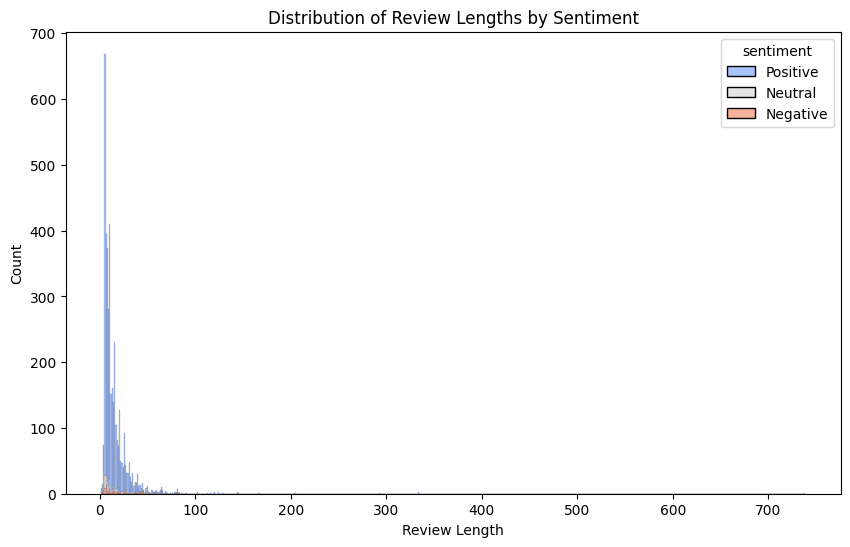

In [54]:
# Adding a column for review length
train_data['review_length'] = train_data['reviews.text'].apply(len)

# Plot the distribution of review lengths for each sentiment category
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='review_length', hue='sentiment', multiple='stack', palette='coolwarm')
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

<Figure size 1200x600 with 0 Axes>

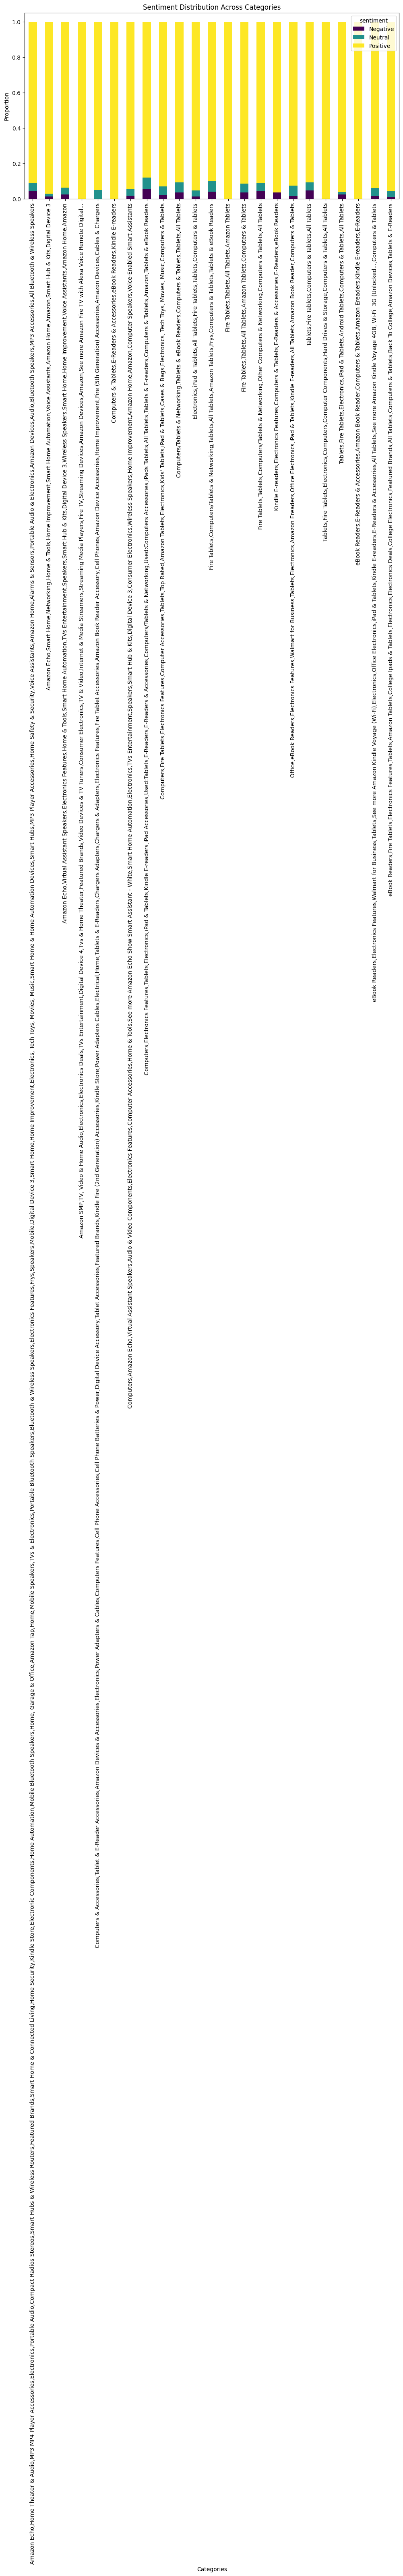

In [55]:
# Analyze sentiment distribution across different categories
plt.figure(figsize=(12, 6))
category_sentiment = train_data.groupby('categories')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
category_sentiment.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title('Sentiment Distribution Across Categories')
plt.xlabel('Categories')
plt.ylabel('Proportion')
plt.show()

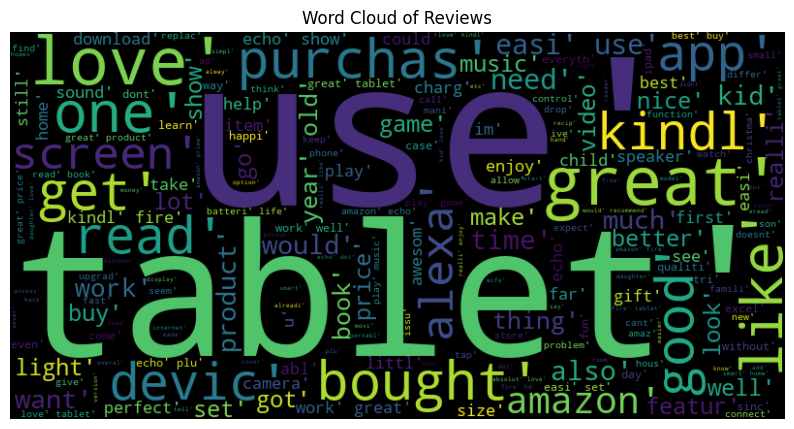

In [56]:
# Example word cloud
text = ' '.join(train_data['reviews.text'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_11584\178224859.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_data.corr()


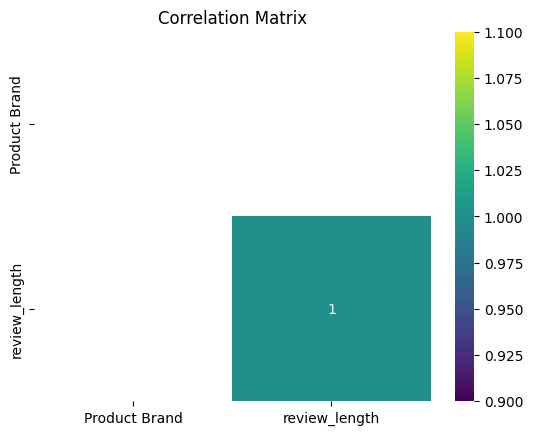

In [57]:
# Correlation matrix
corr_matrix = train_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

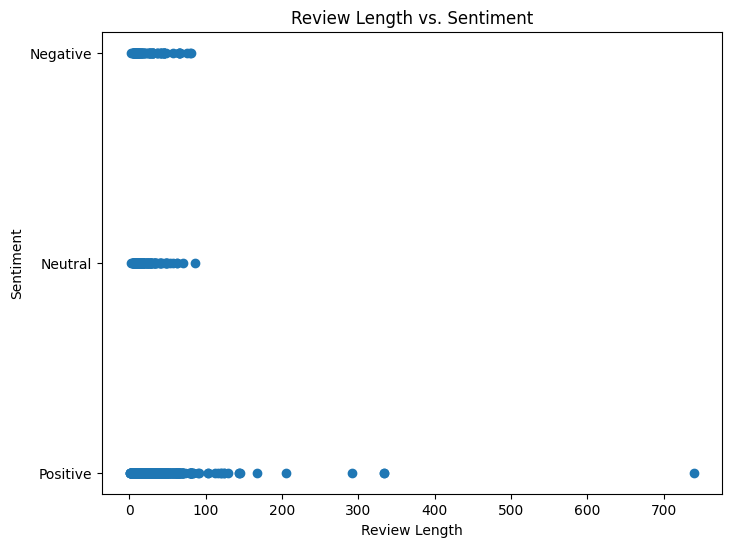

In [58]:
# Scatter plot of review length vs. sentiment
plt.figure(figsize=(8, 6))
plt.scatter(train_data['review_length'], train_data['sentiment'])
plt.title('Review Length vs. Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Sentiment')
plt.show()


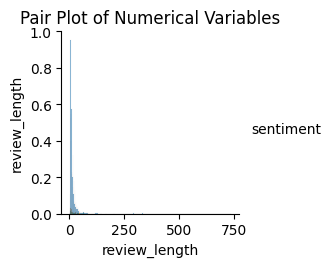

In [59]:
# Pair plot of selected numerical variables
sns.pairplot(train_data[['review_length', 'sentiment']], hue='sentiment', diag_kind='hist')
plt.title('Pair Plot of Numerical Variables')
plt.show()


### Feature enginering

In [60]:
# Convert list-like text data to strings
train_data['reviews.text'] = train_data['reviews.text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
test_data['reviews.text'] = test_data['reviews.text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
hidden_test_data['reviews.text'] = hidden_test_data['reviews.text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [61]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

In [62]:
# Fit and transform the 'reviews.text' column of train_data
tfidf_train = tfidf_vectorizer.fit_transform(train_data['reviews.text'].astype('str'))
tfidf_test = tfidf_vectorizer.transform(test_data['reviews.text'].astype('str'))
tfidf_hidden_test = tfidf_vectorizer.transform(hidden_test_data['reviews.text'].astype('str'))


In [63]:
# Convert the TF-IDF matrices to DataFrames for visualization
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_hidden_test_df = pd.DataFrame(tfidf_hidden_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [64]:
# Print the shape of the resulting DataFrames
print(f"TF-IDF Train Data Shape: {tfidf_train_df.shape}")
print(f"TF-IDF Test Data Shape: {tfidf_test_df.shape}")
print(f"TF-IDF Hidden Test Data Shape: {tfidf_hidden_test_df.shape}")

TF-IDF Train Data Shape: (4000, 1000)
TF-IDF Test Data Shape: (1000, 1000)
TF-IDF Hidden Test Data Shape: (1000, 1000)


In [65]:
# Save TF-IDF DataFrames to CSV files
tfidf_train_df.to_csv("tfidf_train_df.csv", index=False)
tfidf_test_df.to_csv("tfidf_test_df.csv", index=False)
tfidf_hidden_test_df.to_csv("tfidf_hidden_test_df.csv", index=False)

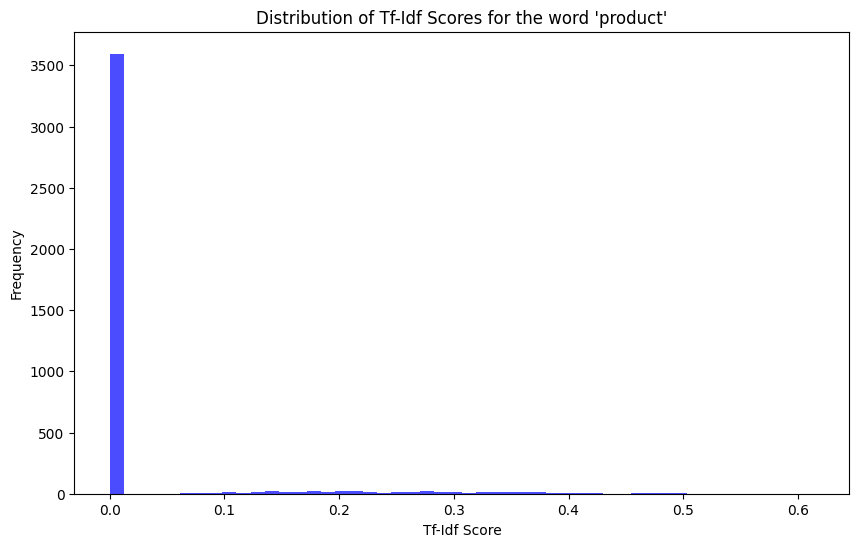

In [66]:
# Visualize the distribution of Tf-Idf scores for specific words
word = 'product'
tfidf_scores = tfidf_train_df[word]
plt.figure(figsize=(10, 6))
plt.hist(tfidf_scores, bins=50, color='blue', alpha=0.7)
plt.title(f"Distribution of Tf-Idf Scores for the word '{word}'")
plt.xlabel("Tf-Idf Score")
plt.ylabel("Frequency")
plt.show()

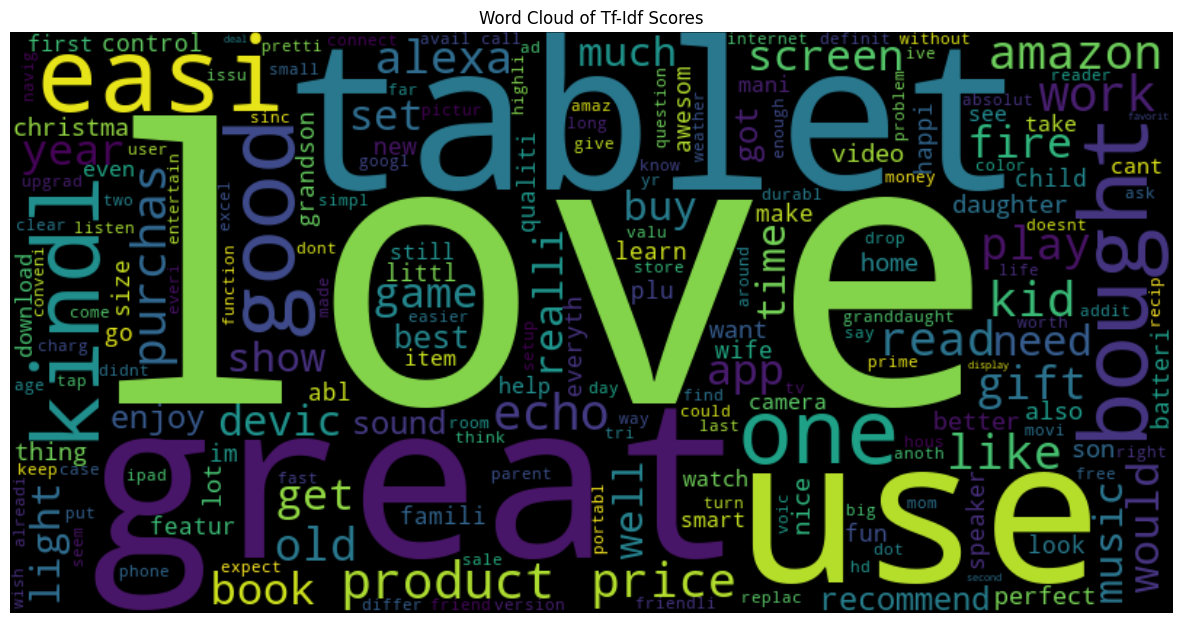

In [67]:
# Generate and visualize a word cloud based on Tf-Idf scores
tfidf_scores_sum = tfidf_train_df.sum(axis=0)
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(tfidf_scores_sum)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.title("Word Cloud of Tf-Idf Scores")
plt.show()

In [68]:
# Merge test_data and hidden_test_data
merged_data = pd.concat([test_data, hidden_test_data], ignore_index=True)

# Print the merged dataset for verification
print("Merged Dataset:")
merged_data.head()

Merged Dataset:


,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",0,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,amazon kindl fire lot free app use one want ge...,"[handi, devic]",NaN
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,echo show great addit amazon famili work like ...,"[anoth, winner, amazon]",NaN
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",0,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,great valu best buy bought christma sale,"[simpl, use, reliabl, far]",NaN
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",0,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,use mine email facebook game go line also load...,[love],NaN
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,fantast item person bought love,[fantast],NaN


In [69]:
merged_data.shape

(2000, 8)

In [70]:
merged_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')

In [71]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  2000 non-null   object
 1   Product Brand        2000 non-null   int32 
 2   categories           2000 non-null   object
 3   primaryCategories    2000 non-null   object
 4   reviews.date         2000 non-null   object
 5   reviews.text         2000 non-null   object
 6   reviews.title        2000 non-null   object
 7   sentiment            1000 non-null   object
dtypes: int32(1), object(7)
memory usage: 117.3+ KB


In [72]:
merged_data.isnull().sum()

Name of the product       0
Product Brand             0
categories                0
primaryCategories         0
reviews.date              0
reviews.text              0
reviews.title             0
sentiment              1000
dtype: int64

In [73]:
# Define X (features) and y (target)
X = merged_data[['Name of the product', 'Product Brand', 'categories',
                 'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title']]
y = merged_data['sentiment']

In [74]:
# Impute missing values in y (sentiment)
imputer = SimpleImputer(strategy='most_frequent')
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Update the DataFrame with imputed values
merged_data['sentiment'] = y_imputed

# Verify that missing values have been handled
print("\nAfter handling missing values:")
print(merged_data.isnull().sum())


After handling missing values:
Name of the product    0
Product Brand          0
categories             0
primaryCategories      0
reviews.date           0
reviews.text           0
reviews.title          0
sentiment              0
dtype: int64


In [75]:
# Create a new column 'combined_text' by concatenating 'reviews.text' and 'reviews.title'
merged_data['combined_text'] = merged_data['reviews.text'].astype(str) + ' ' + merged_data['reviews.title'].astype(str)

In [76]:
merged_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment', 'combined_text'],
      dtype='object')

In [77]:
# Define X (features) and y (target)
X = merged_data['combined_text']
y = merged_data['sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
# Feature extraction: Convert text data to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust the max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [79]:
# Initialize and train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [80]:
# Predictions on the test set
y_pred = nb_classifier.predict(X_test_tfidf)
y_pred

array(['Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positi

In [81]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.95


In [82]:
# Print classification report (precision, recall, F1-score)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         7
     Neutral       0.00      0.00      0.00        11
    Positive       0.95      1.00      0.98       382

    accuracy                           0.95       400
   macro avg       0.32      0.33      0.33       400
weighted avg       0.91      0.95      0.93       400



c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [83]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  0   0   7]
 [  0   0  11]
 [  0   0 382]]


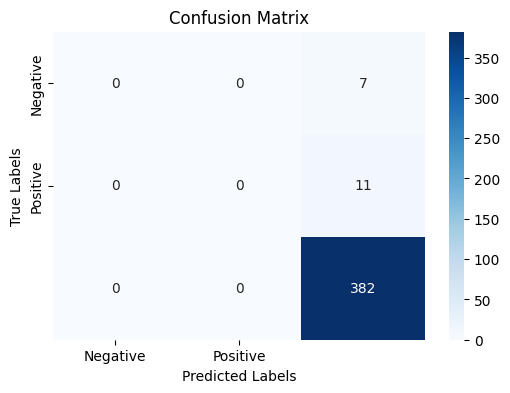

In [84]:
# Assuming you already have the confusion matrix 'conf_matrix'
class_labels = ['Negative', 'Positive']  # Replace with your actual class labels

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [85]:
import joblib
# Save the trained model to a file
joblib.dump(nb_classifier, 'multinomial_nb_model.pkl')

['multinomial_nb_model.pkl']

In [86]:
# Define a function to preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

# Apply the preprocessing function to the 'reviews.text' column
train_data['reviews.text'] = train_data['reviews.text'].apply(preprocess_text)

# Verify preprocessing
train_data['reviews.text'].head()

0    purchas black fridaypro great price even salev...
1    purchas two amazon echo plu two dot plu four f...
2    averag alexa option show thing screen still limit
3                 good product exactli want good price
4    rd one ive purchas ive bought one niec case co...
Name: reviews.text, dtype: object

In [87]:
#  Feature Extraction
# Use CountVectorizer to transform text data into feature vectors
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_data['reviews.text'])

# Labels
y = train_data['sentiment']

# Save the vectorizer for future use
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [88]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(3200, 3715) (800, 3715) (3200,) (800,)


### Handling Class Imbalance with SMOTEENN (Combined Oversampling and Undersampling)

In [89]:
# Initialize SMOTEENN (combination of SMOTE and Edited Nearest Neighbors)
smote_enn = SMOTEENN(random_state=42)

# Apply SMOTEENN to the training data
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Check the shape after resampling
print(X_train_res.shape, y_train_res.shape)

(5005, 3715) (5005,)


In [90]:
# Initialize the classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_res, y_train_res)

# Save the trained model
joblib.dump(nb_classifier, 'naive_bayes_model.pkl')

['naive_bayes_model.pkl']

In [91]:
# Make predictions on the validation set
y_val_pred = nb_classifier.predict(X_val)

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.19      0.62      0.29        13
     Neutral       0.09      0.56      0.15        36
    Positive       0.98      0.69      0.81       751

    accuracy                           0.68       800
   macro avg       0.42      0.62      0.41       800
weighted avg       0.92      0.68      0.77       800

Confusion Matrix:
[[  8   5   0]
 [  3  20  13]
 [ 32 202 517]]


In [92]:
# Apply the same preprocessing function
test_data['reviews.text'] = test_data['reviews.text'].apply(preprocess_text)

# Transform the test data using the saved vectorizer
X_test = vectorizer.transform(test_data['reviews.text'])

# Predict the sentiment using the loaded model
y_test_pred = nb_classifier.predict(X_test)

# Print predictions
print(y_test_pred)

# Evaluate the model if actual sentiments are available in test data
if 'sentiment' in test_data.columns:
    y_test_actual = test_data['sentiment']
    print("Classification Report:")
    print(classification_report(y_test_actual, y_test_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_actual, y_test_pred))
else:
    print("Test data does not contain 'sentiment' column. Predictions have been saved.")

['Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Neutral' 'Positive' 'Positive' 'Neutral' 'Positive' 'Neutral'
 'Positive' 'Positive' 'Positive' 'Positive' 'Neutral' 'Positive'
 'Neutral' 'Positive' 'Neutral' 'Neutral' 'Positive' 'Positive' 'Negative'
 'Neutral' 'Neutral' 'Positive' 'Positive' 'Positive' 'Neutral' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Neutral'
 'Neutral' 'Positive' 'Neutral' 'Negative' 'Positive' 'Positive'
 'Positive' 'Positive' 'Negative' 'Positive' 'Positive' 'Positive'
 'Neutral' 'Neutral' 'Neutral' 'Neutral' 'Positive' 'Positive' 'Positive'
 'Negative' 'Neutral' 'Positive' 'Positive' 'Positive' 'Positive'
 'Neutral' 'Positive' 'Positive' 'Positive' 'Neutral' 'Neutral' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Neutral' 'Positive'
 'Negative' 'Neutral' 'Positive' 'Negative' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positi

In [93]:
# Save predictions to a CSV file
test_data['predicted_sentiment'] = y_test_pred
test_data.to_csv('test_data_with_predictions.csv', index=False)
print("Predictions saved to 'test_data_with_predictions.csv'")

Predictions saved to 'test_data_with_predictions.csv'


In [94]:
test_data.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,predicted_sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",0,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,amazon kindl fire lot free app use one want ge...,"[handi, devic]",Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,echo show great addit amazon famili work like ...,"[anoth, winner, amazon]",Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",0,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,great valu best buy bought christma sale,"[simpl, use, reliabl, far]",Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",0,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,use mine email facebook game go line also load...,[love],Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,fantast item person bought love,[fantast],Positive


In [95]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  1000 non-null   object
 1   Product Brand        1000 non-null   int32 
 2   categories           1000 non-null   object
 3   primaryCategories    1000 non-null   object
 4   reviews.date         1000 non-null   object
 5   reviews.text         1000 non-null   object
 6   reviews.title        1000 non-null   object
 7   predicted_sentiment  1000 non-null   object
dtypes: int32(1), object(7)
memory usage: 58.7+ KB


In [96]:
test_data.isnull().sum()

Name of the product    0
Product Brand          0
categories             0
primaryCategories      0
reviews.date           0
reviews.text           0
reviews.title          0
predicted_sentiment    0
dtype: int64

In [97]:
test_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'predicted_sentiment'],
      dtype='object')

### Tackling Class Imbalance:

In [98]:
train_data.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_length
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",0,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,purchas black fridaypro great price even salev...,"[power, tablet]",Positive,40
1,Amazon - Echo Plus w/ Built-In Hub - Silver,0,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,purchas two amazon echo plu two dot plu four f...,"[amazon, echo, plu, awesom]",Positive,62
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,averag alexa option show thing screen still limit,[averag],Neutral,8
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",0,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,good product exactli want good price,[greattttttt],Positive,6
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",0,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,rd one ive purchas ive bought one niec case co...,[durabl],Positive,17


In [99]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  4000 non-null   object
 1   Product Brand        4000 non-null   int32 
 2   categories           4000 non-null   object
 3   primaryCategories    4000 non-null   object
 4   reviews.date         4000 non-null   object
 5   reviews.text         4000 non-null   object
 6   reviews.title        4000 non-null   object
 7   sentiment            4000 non-null   object
 8   review_length        4000 non-null   int64 
dtypes: int32(1), int64(1), object(7)
memory usage: 265.8+ KB


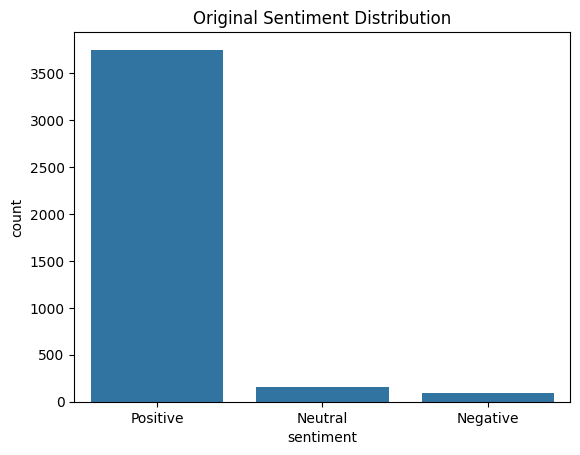

In [100]:
# Visualize Original Sentiment Distribution
sns.countplot(x='sentiment', data=train_data)
plt.title('Original Sentiment Distribution')
plt.show()

In [101]:
# Feature and Target Separation
X = train_data['reviews.text']
y = train_data['sentiment']

# Vectorize Text Data Using Tf-Idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [102]:
# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

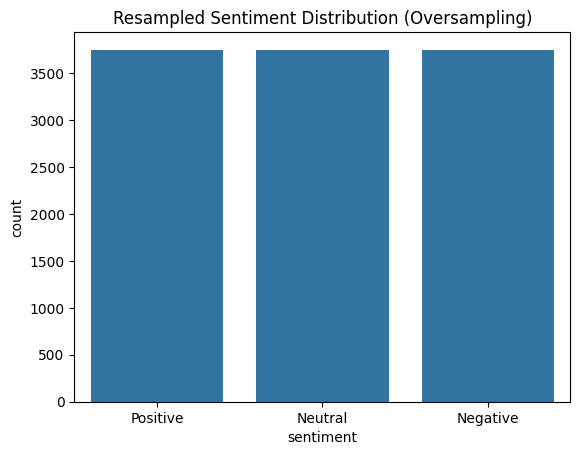

In [103]:
# Visualize Resampled Sentiment Distribution
sns.countplot(x=y_resampled)
plt.title('Resampled Sentiment Distribution (Oversampling)')
plt.show()


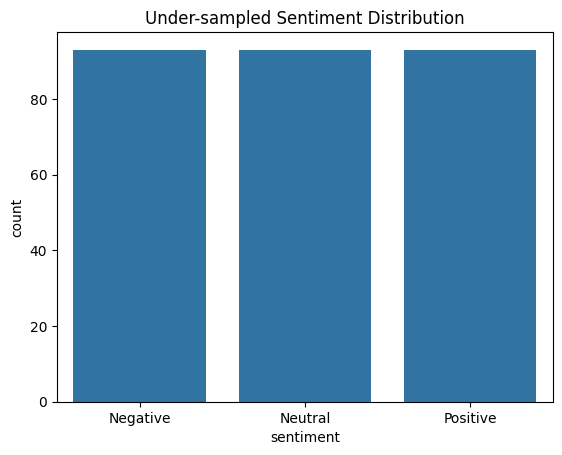

In [104]:
# Under-sampling Majority Class
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_tfidf, y)

# Visualize Under-sampled Sentiment Distribution
sns.countplot(x=y_under)
plt.title('Under-sampled Sentiment Distribution')
plt.show()

In [105]:
# Train Classifier with Resampled Data (Oversampling)
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [106]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_res, y_train_res)

y_pred_res = nb_classifier.predict(X_val_res)


In [107]:
print(classification_report(y_val_res, y_pred_res))

              precision    recall  f1-score   support

    Negative       0.96      1.00      0.98       748
     Neutral       0.92      0.99      0.96       733
    Positive       1.00      0.88      0.94       769

    accuracy                           0.96      2250
   macro avg       0.96      0.96      0.96      2250
weighted avg       0.96      0.96      0.96      2250



In [108]:
print("Confusion Matrix (Oversampling):")
print(confusion_matrix(y_val_res, y_pred_res))

Confusion Matrix (Oversampling):
[[748   0   0]
 [  2 728   3]
 [ 29  61 679]]


In [109]:
# Calculate Evaluation Metrics
precision = precision_score(y_val_res, y_pred_res, average='weighted')
recall = recall_score(y_val_res, y_pred_res, average='weighted')
f1 = f1_score(y_val_res, y_pred_res, average='weighted')
y_pred_proba_res = nb_classifier.predict_proba(X_val_res)
auc_roc = roc_auc_score(y_val_res, y_pred_proba_res, multi_class='ovr')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC-ROC: {auc_roc}')

Precision: 0.9600802070966199
Recall: 0.9577777777777777
F1-Score: 0.9572181262003828
AUC-ROC: 0.9976376809847669


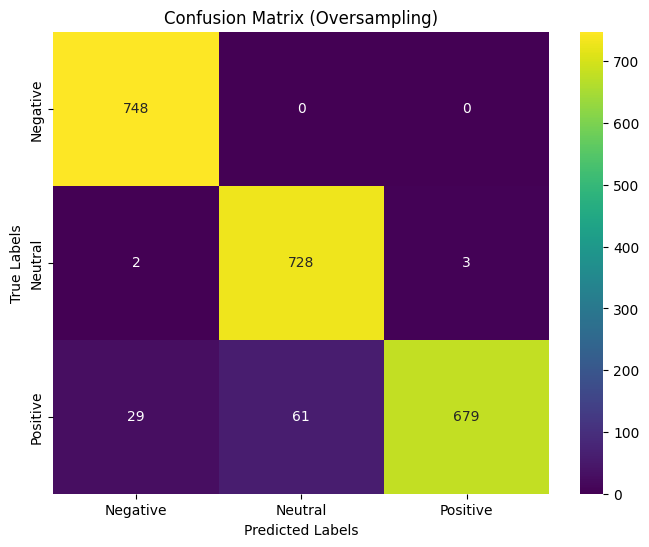

In [110]:
# Define the confusion matrix
conf_matrix = np.array([[748, 0, 0],
                        [2, 728, 3],
                        [29, 61, 679]])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Oversampling)')
plt.show()

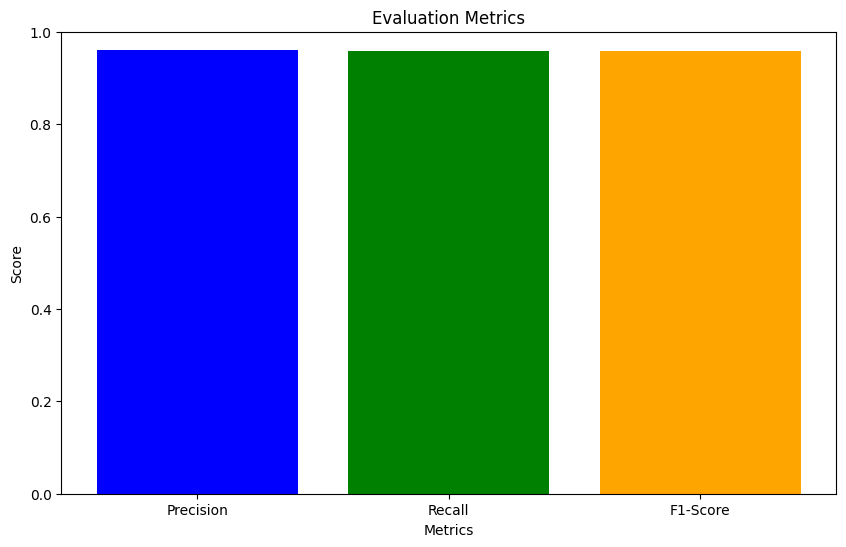

In [111]:
# Visualize precision, recall, f1-score
metrics = ['Precision', 'Recall', 'F1-Score']
scores = [precision, recall, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color=['blue', 'green', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.ylim(0, 1.0)
plt.show()

In [112]:
# AUC-ROC requires probability estimates of the positive class
y_pred_proba = nb_classifier.predict_proba(X_val)
auc_roc = roc_auc_score(pd.get_dummies(y_val), y_pred_proba, multi_class='ovr')

In [113]:
# Save evaluation metrics in a dictionary
evaluation_metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC-ROC': auc_roc
}

# Save evaluation results to a text file
with open('classification_report.txt', 'w') as f:
    f.write('Evaluation Metrics:\n')
    for metric, value in evaluation_metrics.items():
        f.write(f'{metric}: {value:.4f}\n')
    f.write('\nClassification Report:\n')
    f.write(classification_report(y_val_res, y_pred_res))
    f.write('\nConfusion Matrix:\n')
    f.write(str(confusion_matrix(y_val_res, y_pred_res)))

print('Evaluation results saved to classification_report.txt')

Evaluation results saved to classification_report.txt


In [114]:
train_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_length
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",0,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,purchas black fridaypro great price even salev...,"[power, tablet]",Positive,40
1,Amazon - Echo Plus w/ Built-In Hub - Silver,0,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,purchas two amazon echo plu two dot plu four f...,"[amazon, echo, plu, awesom]",Positive,62


In [115]:
test_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,predicted_sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",0,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,amazon kindl fire lot free app use one want ge...,"[handi, devic]",Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,echo show great addit amazon famili work like ...,"[anoth, winner, amazon]",Positive


# Model Selection and Advanced Techniques

In [116]:
# Vectorize text data using Tf-Idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)  # X is your text data

In [117]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [118]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest (OvR) strategy
svm_classifier.fit(X_train, y_train)
svm_classifier

SVC(kernel='linear')

In [119]:
# Predictions on validation set
y_pred_svm = svm_classifier.predict(X_val)
y_pred_svm

array(['Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positi

In [120]:
# Evaluate SVM
accuracy_svm = accuracy_score(y_val, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.4f}')


SVM Accuracy: 0.9463


In [121]:
# Classification report
print('Classification Report (SVM):')
print(classification_report(y_val, y_pred_svm))

Classification Report (SVM):
              precision    recall  f1-score   support

    Negative       1.00      0.23      0.38        13
     Neutral       1.00      0.08      0.15        36
    Positive       0.95      1.00      0.97       751

    accuracy                           0.95       800
   macro avg       0.98      0.44      0.50       800
weighted avg       0.95      0.95      0.93       800



In [122]:
# Evaluate SVM
accuracy_svm = accuracy_score(y_val, y_pred_svm)
classification_rep_svm = classification_report(y_val, y_pred_svm)

In [123]:
# Save to a file
with open('svm_classification_report.txt', 'w') as f:
    f.write(f'SVM Accuracy: {accuracy_svm:.4f}\n')
    f.write('Classification Report (SVM):\n')
    f.write(classification_rep_svm)

print('SVM evaluation results saved to svm_classification_report.txt')

SVM evaluation results saved to svm_classification_report.txt


### Neural Networks (using TensorFlow/Keras)

In [124]:
# Separate features and target
X = train_data['reviews.text']  # Assuming 'reviews.text' contains the review text
y = train_data['sentiment']  # Assuming 'sentiment' is the target variable

In [125]:
# Vectorize text data using Tf-Idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [126]:
from tensorflow.keras.utils import to_categorical
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [127]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y_categorical, test_size=0.2, random_state=42)


In [128]:
# Define neural network model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [129]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [130]:
# Train the model
model.fit(X_train.toarray(), y_train, epochs=10, batch_size=32, validation_data=(X_val.toarray(), y_val))

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.8963 - loss: 0.5078 - val_accuracy: 0.9388 - val_loss: 0.2287
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9385 - loss: 0.1919 - val_accuracy: 0.9388 - val_loss: 0.2103
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9322 - loss: 0.1542 - val_accuracy: 0.9425 - val_loss: 0.2152
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9430 - loss: 0.1120 - val_accuracy: 0.9588 - val_loss: 0.2373
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9820 - loss: 0.0606 - val_accuracy: 0.9538 - val_loss: 0.2905
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9921 - loss: 0.0255 - val_accuracy: 0.9525 - val_loss: 0.3385
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9998 - loss: 0.0073 - val_accuracy: 0.9538 - val_loss: 0.3827
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9992 - loss: 0.0040 - val_accu

In [131]:
# Predictions on validation set
y_pred_proba = model.predict(X_val.toarray())
y_pred_nn = np.argmax(y_pred_proba, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [132]:
# Convert one-hot encoded y_val back to labels
y_val_labels = np.argmax(y_val, axis=1)

In [133]:
# Evaluate neural network
accuracy_nn = accuracy_score(y_val_labels, y_pred_nn)
accuracy_nn

0.9475

In [134]:
classification_rep_nn = classification_report(y_val_labels, y_pred_nn)
print("classification_rep_nn")
print(classification_rep_nn)

classification_rep_nn
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.41      0.25      0.31        36
           2       0.96      0.99      0.97       751

    accuracy                           0.95       800
   macro avg       0.76      0.64      0.69       800
weighted avg       0.94      0.95      0.94       800



In [135]:
# Save to a file
with open('nn_classification_report.txt', 'w') as f:
    f.write(f'Neural Network Accuracy: {accuracy_nn:.4f}\n')
    f.write('Classification Report (Neural Network):\n')
    f.write(classification_rep_nn)

print('Neural Network evaluation results saved to nn_classification_report.txt')

Neural Network evaluation results saved to nn_classification_report.txt


In [136]:
# Ensemble Techniques

from sklearn.ensemble import VotingClassifier
import xgboost as xgb

# Separate features and target
X = train_data['reviews.text']  # Assuming 'reviews.text' contains the review text
y = train_data['sentiment']  # Assuming 'sentiment' is the target variable

In [137]:
# Vectorize text data using Tf-Idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [138]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [139]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

In [140]:
# Oversample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [141]:
# Train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [142]:
# Train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [143]:
# Combine models using VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[
    ('nb', nb_classifier),
    ('xgb', xgb_classifier)
], voting='soft')

# Train the ensemble classifier
ensemble_classifier.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('nb', MultinomialNB()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

In [144]:
# Predictions on validation set
y_pred_ensemble = ensemble_classifier.predict(X_val)

In [145]:
# Evaluate ensemble model
accuracy_ensemble = accuracy_score(y_val, y_pred_ensemble)
accuracy_ensemble

0.94625

In [146]:
classification_rep_ensemble = classification_report(y_val, y_pred_ensemble)
print(classification_rep_ensemble)

              precision    recall  f1-score   support

           0       0.47      0.69      0.56        13
           1       0.56      0.25      0.35        36
           2       0.97      0.98      0.97       751

    accuracy                           0.95       800
   macro avg       0.67      0.64      0.63       800
weighted avg       0.94      0.95      0.94       800



In [147]:
# Save to a file
with open('ensemble_classification_report.txt', 'w') as f:
    f.write(f'Ensemble Model Accuracy: {accuracy_ensemble:.4f}\n')
    f.write('Classification Report (Ensemble Model):\n')
    f.write(classification_rep_ensemble)

print('Ensemble model evaluation results saved to ensemble_classification_report.txt')

Ensemble model evaluation results saved to ensemble_classification_report.txt


### VADER Sentiment Analyzer

In [148]:
analyzer = SentimentIntensityAnalyzer()
analyzer

In [149]:
# Perform Sentiment Analysis and Create Sentiment Score Feature

sentiment_scores = []

for text in train_data['reviews.text']:
    vs = analyzer.polarity_scores(text)
    sentiment_scores.append(vs['compound'])  # Compound score as sentiment score

train_data['sentiment_score'] = sentiment_scores
sentiment_scores

[0.9442,
 0.9274,
 0.0,
 0.7269,
 0.128,
 0.7783,
 0.8955,
 0.7717,
 0.891,
 0.0,
 0.6369,
 0.7579,
 0.7964,
 0.4215,
 0.0,
 0.8519,
 0.6597,
 0.7003,
 0.3134,
 0.9442,
 0.0,
 0.9246,
 0.1119,
 0.0,
 0.4767,
 0.9201,
 0.7845,
 0.4215,
 0.9231,
 0.2263,
 0.8225,
 0.34,
 0.6249,
 0.6249,
 0.7579,
 0.6597,
 0.7906,
 0.7906,
 0.959,
 0.6597,
 0.763,
 0.7351,
 0.0,
 0.2878,
 0.7845,
 0.6249,
 0.1779,
 0.3612,
 0.5994,
 0.8701,
 0.5096,
 0.765,
 0.8591,
 0.5574,
 0.9337,
 0.0,
 0.4404,
 -0.34,
 0.0,
 0.7506,
 0.0,
 -0.2023,
 0.7351,
 0.4215,
 0.8126,
 0.4215,
 0.7269,
 0.7003,
 0.7845,
 -0.1027,
 0.7506,
 0.7579,
 0.9231,
 0.3612,
 0.0,
 0.4588,
 0.9274,
 0.6369,
 0.0772,
 0.6369,
 0.8271,
 -0.34,
 0.4404,
 0.0258,
 0.6369,
 -0.4019,
 0.6369,
 0.0,
 0.8481,
 0.4939,
 0.7003,
 0.7269,
 0.9201,
 0.7906,
 0.3612,
 -0.4767,
 0.7783,
 0.7553,
 0.765,
 0.9042,
 0.9451,
 0.7964,
 0.765,
 0.8481,
 -0.6377,
 0.8519,
 0.7964,
 0.0,
 0.8316,
 0.6908,
 0.9153,
 0.6249,
 0.8225,
 0.5719,
 0.6369,
 0.3612

In [150]:
train_data.to_csv('train_data_with_sentiment_scores.csv', index=False)

In [151]:
# Normalize sentiment scores to range [0, 1] (if sentiment scores are not in this range)
min_score = min(train_data['sentiment_score'])
max_score = max(train_data['sentiment_score'])
train_data['normalized_sentiment_score'] = (train_data['sentiment_score'] - min_score) / (max_score - min_score)

In [152]:
# Split data into X and y
X = train_data[['reviews.text', 'normalized_sentiment_score']]
y = train_data['sentiment']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:
# Vectorize text data using Tf-Idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X['reviews.text'])

In [154]:
# Combine Tf-Idf vectors with normalized sentiment score
X_combined = np.hstack((X_tfidf.toarray(), X['normalized_sentiment_score'].values.reshape(-1, 1)))
X_combined

array([[0.        , 0.        , 0.11028576, ..., 0.        , 0.        ,
        0.97165796],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.96260574],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.4629021 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.20626111],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.57190581],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.4629021 ]])

#### Naive Bayes Classifier


In [155]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [156]:
# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [157]:
# Predictions and Evaluation
y_pred_nb = nb_classifier.predict(X_val)


In [158]:
# Print accuracy and other evaluation metrics as needed
accuracy_nb = accuracy_score(y_val, y_pred_nb)
print(f'Naive Bayes Accuracy: {accuracy_nb:.4f}')

Naive Bayes Accuracy: 0.9387


In [159]:
# Classification Report and Confusion Matrix
print('Classification Report (Naive Bayes):')
print(classification_report(y_val, y_pred_nb))

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        13
     Neutral       0.00      0.00      0.00        36
    Positive       0.94      1.00      0.97       751

    accuracy                           0.94       800
   macro avg       0.31      0.33      0.32       800
weighted avg       0.88      0.94      0.91       800



c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [160]:
print('Confusion Matrix (Naive Bayes):')
print(confusion_matrix(y_val, y_pred_nb))

Confusion Matrix (Naive Bayes):
[[  0   0  13]
 [  0   0  36]
 [  0   0 751]]


In [161]:
# Save results to a file
with open('naive_bayes_sentiment_analysis.txt', 'w') as f:
    f.write(f'Naive Bayes Accuracy: {accuracy_nb:.4f}\n\n')
    f.write('Classification Report (Naive Bayes):\n')
    f.write(classification_report(y_val, y_pred_nb))
    f.write('\n\nConfusion Matrix (Naive Bayes):\n')
    f.write(str(confusion_matrix(y_val, y_pred_nb)))

print('Results saved to naive_bayes_sentiment_analysis.txt')

Results saved to naive_bayes_sentiment_analysis.txt


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [162]:
# LSTM Implementation for Sentiment Analysis

# Separate features and target
X = train_data['reviews.text']
y = train_data['sentiment']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [163]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
label_encoder

LabelEncoder()

In [164]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [165]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [166]:
# Pad sequences to ensure uniform length
max_length = 100  # Adjust as needed based on your data
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

##### Build LSTM Model

In [167]:
embedding_dim = 100
max_length = 100  # Define the maximum sequence length

model = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim),  # Input_dim should match the size of your tokenizer
    SpatialDropout1D(0.2),
    LSTM(units=100, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [168]:
# Train the LSTM Model

epochs = 10  # Adjust as needed
batch_size = 64

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
early_stopping

In [169]:
from keras.callbacks import ModelCheckpoint

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_lstm_model.keras', save_best_only=True)
checkpoint

In [170]:
# Train the model
history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val_pad, y_val), callbacks=[early_stopping, checkpoint])
history

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.9037 - loss: 0.4828 - val_accuracy: 0.9388 - val_loss: 0.2757
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.9463 - loss: 0.2469 - val_accuracy: 0.9388 - val_loss: 0.2726
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.9398 - loss: 0.2694 - val_accuracy: 0.9388 - val_loss: 0.2727
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9421 - loss: 0.2607 - val_accuracy: 0.9388 - val_loss: 0.2750
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.9401 - loss: 0.2691 - val_accuracy: 0.9388 - val_loss: 0.2733


In [171]:
# Evaluate the LSTM Model

from keras.models import load_model

# Load the best model
best_model = load_model('best_lstm_model.keras')
best_model


<Sequential name=sequential_1, built=True>

In [172]:
# Predict probabilities for each class
y_pred_prob = best_model.predict(X_val_pad)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [173]:
# Convert probabilities to class labels
y_pred_lstm = np.argmax(y_pred_prob, axis=1)

In [174]:
# Print evaluation metrics
print('Classification Report (LSTM):')
print(classification_report(y_val, y_pred_lstm))

Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.00      0.00      0.00        36
           2       0.94      1.00      0.97       751

    accuracy                           0.94       800
   macro avg       0.31      0.33      0.32       800
weighted avg       0.88      0.94      0.91       800



c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [175]:
# Print evaluation metrics
print('Classification Report (LSTM):')
print(classification_report(y_val, y_pred_lstm))

Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.00      0.00      0.00        36
           2       0.94      1.00      0.97       751

    accuracy                           0.94       800
   macro avg       0.31      0.33      0.32       800
weighted avg       0.88      0.94      0.91       800



c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [176]:
print('Confusion Matrix (LSTM):')
print(confusion_matrix(y_val, y_pred_lstm))

Confusion Matrix (LSTM):
[[  0   0  13]
 [  0   0  36]
 [  0   0 751]]


In [177]:
# Save evaluation metrics to a file
with open('lstm_classification_report.txt', 'w') as f:
    f.write('Classification Report (LSTM):\n')
    f.write(classification_report(y_val, y_pred_lstm) + '\n\n')
    f.write('Confusion Matrix (LSTM):\n')
    f.write(np.array2string(conf_matrix) + '\n')

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

###  compare the performance of neural network models with traditional machine learning algorithms,

In [178]:
# Check the structure of the data
train_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_length,sentiment_score,normalized_sentiment_score
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",0,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,purchas black fridaypro great price even salev...,"[power, tablet]",Positive,40,0.9442,0.971658
1,Amazon - Echo Plus w/ Built-In Hub - Silver,0,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,purchas two amazon echo plu two dot plu four f...,"[amazon, echo, plu, awesom]",Positive,62,0.9274,0.962606


In [179]:
hidden_test_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",0,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,amazon kindl fire ha a lot of free app and can...,"[veri, handi, devic]",Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,the echo show is a great addit to the amazon f...,"[anoth, winner, from, amazon]",Positive


In [180]:
test_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,predicted_sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",0,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,amazon kindl fire lot free app use one want ge...,"[handi, devic]",Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,0,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,echo show great addit amazon famili work like ...,"[anoth, winner, amazon]",Positive


In [181]:
# Parameters
max_words = 10000
max_length = 100
embedding_dim = 100

In [182]:
# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['reviews.text'])
tokenizer

In [183]:
X_train_seq = tokenizer.texts_to_sequences(train_data['reviews.text'])
X_val_seq = tokenizer.texts_to_sequences(hidden_test_data['reviews.text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['reviews.text'])


In [184]:
# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [185]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['sentiment'])
y_val = label_encoder.transform(hidden_test_data['sentiment'])
y_test = label_encoder.transform(test_data['predicted_sentiment'])

In [186]:
# Convert labels to categorical for neural network models
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

## Train and Evaluate Traditional Machine Learning Models

In [187]:
# Initialize SVM model with linear kernel
svm_model = SVC(kernel='linear', probability=True)

# Train the SVM model (considering only a subset of data for faster execution)
subset_size = 100  # Example: use a subset of 1000 samples
svm_model.fit(X_train_pad[:subset_size], y_train[:subset_size])

SVC(kernel='linear', probability=True)

In [188]:
# Predictions on test set
y_pred_svm = svm_model.predict(X_test_pad)

In [189]:
# Evaluate performance
print('SVM Accuracy:', svm_model.score(X_test_pad, y_test))
print('Classification Report (SVM):')
print(classification_report(y_test, y_pred_svm))
print('Confusion Matrix (SVM):')
print(confusion_matrix(y_test, y_pred_svm))

SVM Accuracy: 0.608
Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.02      0.02      0.02        58
           1       0.10      0.02      0.03       277
           2       0.67      0.91      0.77       665

    accuracy                           0.61      1000
   macro avg       0.26      0.31      0.27      1000
weighted avg       0.47      0.61      0.52      1000

Confusion Matrix (SVM):
[[  1   4  53]
 [ 29   5 243]
 [ 21  42 602]]


In [194]:
# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_pad, y_train)
y_pred_nb = nb_model.predict(X_test_pad)

In [195]:
print('Naive Bayes Accuracy:', accuracy_score(y_test, y_pred_nb))
print('Classification Report (NB):')
classification_rep_nb = classification_report(y_test, y_pred_nb)
print(classification_rep_nb)

print('Confusion Matrix (NB):')
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print(conf_matrix_nb)

Naive Bayes Accuracy: 0.565
Classification Report (NB):
              precision    recall  f1-score   support

           0       0.06      0.07      0.06        58
           1       0.13      0.03      0.05       277
           2       0.63      0.83      0.72       665

    accuracy                           0.56      1000
   macro avg       0.27      0.31      0.28      1000
weighted avg       0.46      0.56      0.50      1000

Confusion Matrix (NB):
[[  4   1  53]
 [  4   8 265]
 [ 60  52 553]]


### Train and Evaluate Neural Network Models

In [197]:
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, SpatialDropout1D, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

def create_lstm_model(max_words, embedding_dim, max_length):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
model

<Sequential name=sequential_1, built=True>

In [200]:
# Example usage:
max_words = 10000  # Example: maximum number of words in your vocabulary
embedding_dim = 100  # Example: dimensionality of the embedding vector
max_length = 100  # Example: maximum length of your sequences (input_length)

model = "C:\Users\admin\OneDrive\Desktop\capstone-2\best_lstm_model.keras"(max_words, embedding_dim, max_length)
model.summary()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3493680531.py, line 6)

In [190]:
hidden_test_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')

In [191]:
test_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'predicted_sentiment'],
      dtype='object')

In [192]:
train_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment', 'review_length', 'sentiment_score',
       'normalized_sentiment_score'],
      dtype='object')

In [193]:
merged_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment', 'combined_text'],
      dtype='object')